In [1]:
import simulations
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
import mne

## Importing HMP
import hmp

# Initial simulation, all assumptions are true

In [3]:
cpus = 1 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 1000 #Number of trials to simulate
sfreq = 1000
##### Here we define the sources of the brain activity (event) for each trial
n_events = 4
frequency = 10. #Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = 1 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution

names = ['superiorparietal-lh','inferiortemporal-lh','postcentral-lh','postcentral-rh','superiorparietal-lh']#Which source to activate for each event (see atlas when calling simulations.available_sources())
name_file = 'dataset'

means = np.array([50, 100, 250, 200,  150])/shape #Mean duration of the between event times in ms
relations = [1,2,3,4,5] # to which previous event each event is related (1 is stimulus onset)
proportions = [1,1,1,1,1] # How frequent each event is
event_length_samples = [50, 50, 50, 50, 50] # The sampling period of the event (e.g. 100 is full sine)


sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency,  amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, name_file, path='data/', 
            overwrite=False, sfreq=sfreq, noise=False, seed=1234,
            relations=relations, proportions=proportions, 
            event_length_samples=event_length_samples)

#load electrode position, specific to the simulations
positions = simulations.simulation_positions()


/home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/illustration/simulations.py:190: UserWarning: data/dataset_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


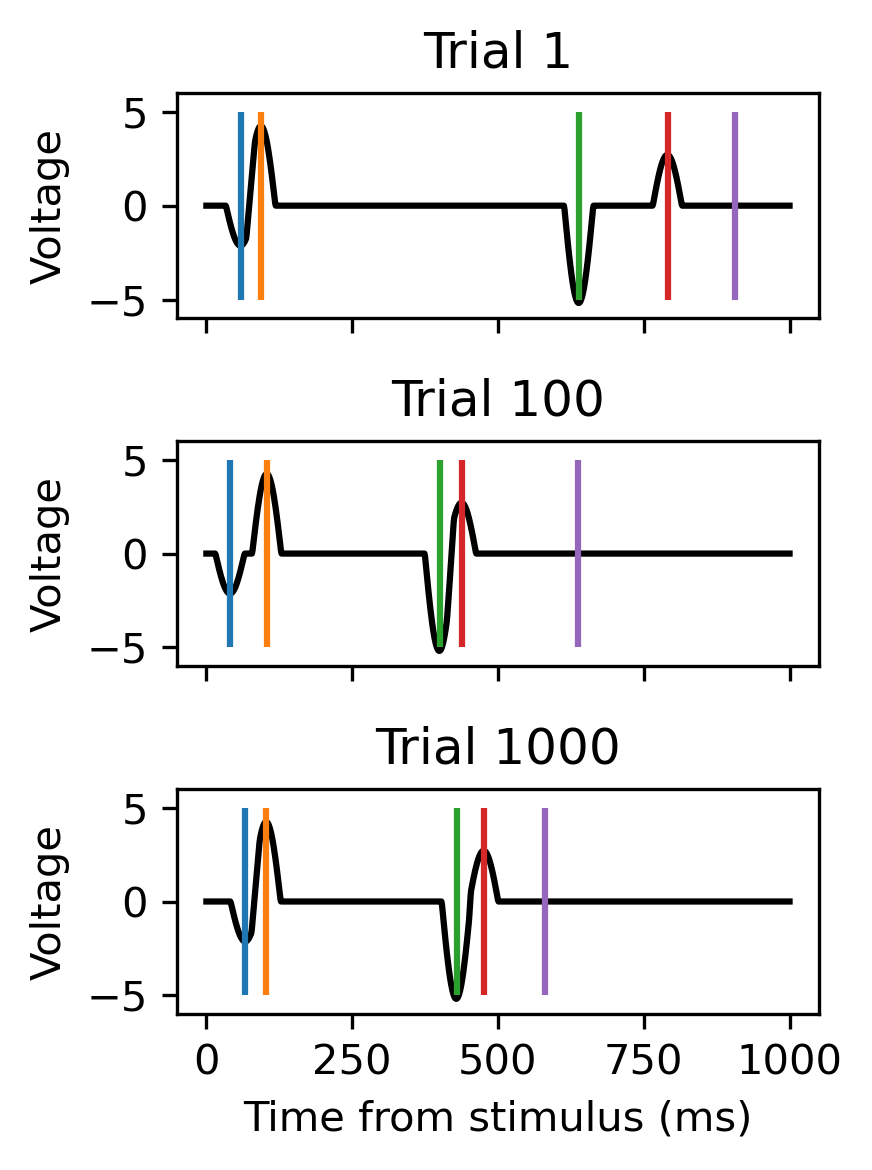

In [6]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}

color_dict = {i: color for i, color in enumerate(sns.color_palette(None, n_events+1))}

sim_source_times = np.zeros((n_trials, n_events+2))*np.nan
for event in np.unique(events[:,2]):
    sim_source_times[:,event-1] = events[events[:,2] == event,0]
sim_source_times -= np.tile(sim_source_times[:,0], (n_events+2,1)).T
diff_source_times_true = np.diff(sim_source_times)
sim_source_times_true = sim_source_times[1:]

raw = mne.io.read_raw_fif(file[0], preload=True, verbose=False)
epochs =  mne.Epochs(raw, events = events, event_id=event_id, 
                    tmin = 0, tmax=1, baseline=None, preload=True)
epochs.pick(['EEG 038'])

fig, ax = plt.subplots(3,1, figsize=(3,4), dpi=300, sharex=True, sharey=True)

for i,trial in enumerate([0,99,999]):
    ax[i].plot(np.linspace(0,1000,1001),epochs[trial].average().pick_types(eeg=True).get_data().T, color='k')
    ax[i].set_ylabel('Voltage')
    ax[i].set_yticks([-5,0,5])
    for event in range(1, n_events+2):
        ax[i].vlines(sim_source_times[trial,event], ymin=5, ymax=-5, color=color_dict[event-1], alpha=1) 
    ax[i].set_title('Trial %i'%(trial+1))
    i += 1
ax[2].set_xlabel('Time from stimulus (ms)')
ax[0].set_ylim(-6,6)
plt.tight_layout()
plt.savefig('plots/ERPs_all_elec.png',dpi=300,transparent=True,bbox_inches='tight')

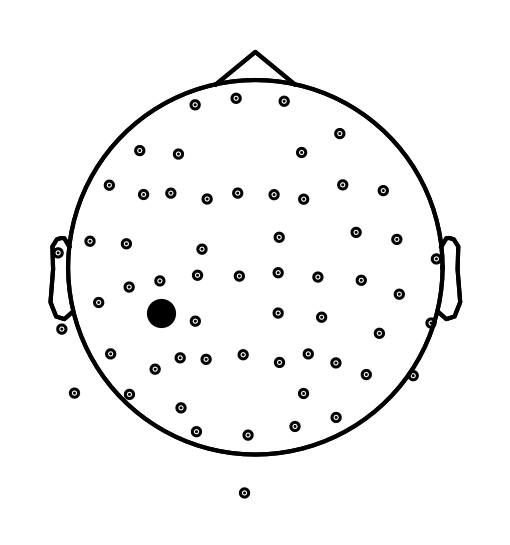

<Figure size 640x480 with 0 Axes>

In [13]:
fig, ax = plt.subplots(1,1,figsize=(2.1,2.1), dpi=300)
mne.viz.plot_montage(raw.info.get_montage(), show=False, show_names=False, scale_factor=.5, axes=ax)
raw_pick = raw.copy().pick(['EEG 038'])
mne.viz.plot_montage(raw_pick.info.get_montage(), show=True, show_names=False, scale_factor=50, axes=ax)
plt.savefig('plots/montage.png',dpi=300,transparent=True,bbox_inches='tight')

Processing participant data/dataset_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant data/dataset_raw.fif


  0%|          | 0/771 [00:00<?, ?it/s]

Transition event 1 found around sample 51
Transition event 2 found around sample 162
Transition event 3 found around sample 412
Transition event 4 found around sample 619

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


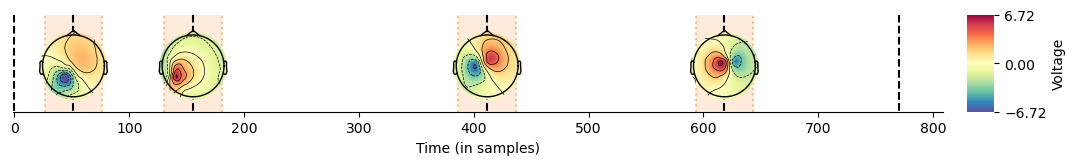

In [7]:
# Reading the data
eeg_data_true = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

# Transforming to PC space
hmp_data_true = hmp.utils.transform_data(eeg_data_true, apply_standard=False, n_comp=5)

# Fitting
init_true = hmp.models.hmp(data=hmp_data_true)
estimates_true = init_true.fit()#

#Plotting
hmp.visu.plot_topo_timecourse(eeg_data_true, estimates_true, positions, init_true, magnify=1, sensors=False, times_to_display = np.mean(sim_source_times_true,axis=0))

In [8]:
baseline, n_samples = -100, 100
q = np.linspace(5,95, 10)
true_topologies = init_true.compute_topologies(eeg_data_true, estimates_true, init_true, mean=True)

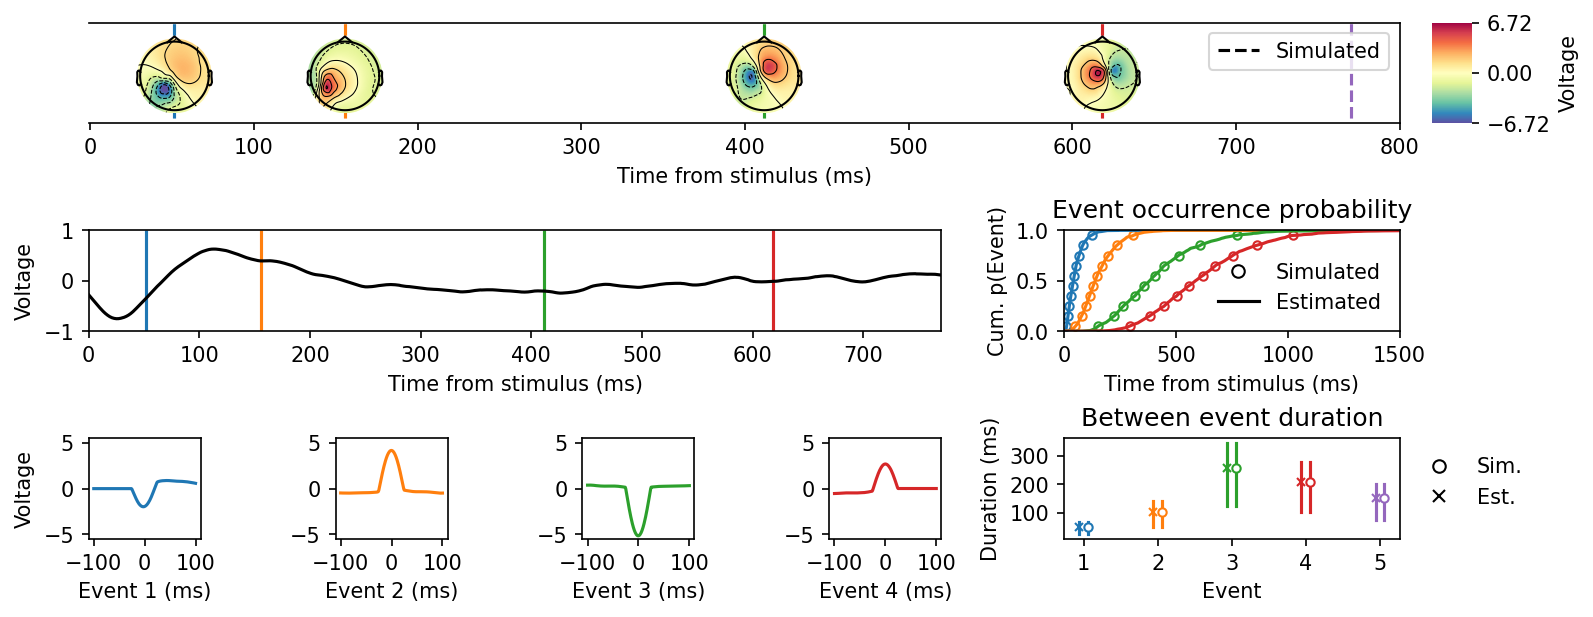

In [12]:
eeg_data = eeg_data_true
init = init_true
estimates = estimates_true
sim_source_times = sim_source_times_true
diff_source_times = diff_source_times_true

fig = plt.figure(constrained_layout=True, figsize=(12, 4), dpi=150)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
ax0 = fig.add_subplot(gs[0, :5])
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, 
            times_to_display = np.mean(sim_source_times[:,1:],axis=0), ax=ax0, colorbar=True,event_lines=None, linecolors=list(color_dict.values()))
ax0.set_xlabel("Time from stimulus (ms)")
ax0.plot([], [], ls='--', color='k', label='Simulated')
ax0.legend()

data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")

times = init.compute_times(init, estimates, fill_value=0, add_rt=True)

# Plotting the ERP
ax1 = fig.add_subplot(gs[1, :4])

# Plotting the single trial aligned events
baseline, n_samples = -100, 100
for i, event in enumerate(times.event[1:-1]):
    ax1.vlines(times.mean('trial_x_participant')[event], -1, 1, color=color_dict[i])
    ax = fig.add_subplot(gs[2, i])
    centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=event, baseline=baseline, n_samples=n_samples)
    ax.plot(centered.samples, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_dict[i])
    ax.set(xlabel=f"Event {event.values} (ms)", ylim=(-5.5, 5.5))
    if i == 0:
        ax.set_ylabel("Voltage")

centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=0, n_samples=800, baseline=0)
ax1.plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color='k')
ax1.set(ylim=(-1, 1), xlim=(0, times.mean('trial_x_participant')[-1]), xlabel='Time from stimulus (ms)', ylabel='Voltage')

durations = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
times = init.compute_times(init, estimates, duration=False, mean=False, add_rt=True).T
probs_mean = estimates.eventprobs.mean('trial_x_participant')


# Plotting durations and event probabilities
ax2_0 = fig.add_subplot(gs[1, 4])
for i in range(n_events):
    ax2_0.plot(np.percentile(sim_source_times[:,i+1],q),q/100, 'o', markerfacecolor='w', color=color_dict[i], ms=4, zorder=-1)
    ax2_0.plot(probs_mean[:,i].cumsum(), ls='-', color=color_dict[i])
ax2_0.set(xlim=(0, 1500), ylim=(0, 1), ylabel="Cum. p(Event)", xlabel="Time from stimulus (ms)", title='Event occurrence probability')
ax2_0.plot([], [], 'o', color='k', markerfacecolor='w', label='Simulated')
ax2_0.plot([], [], '-', color='k', label='Estimated')
ax2_0.legend(loc="lower right", frameon=False)

ax2_1 = fig.add_subplot(gs[2, 4])
for i in range(n_events+1):
    ax2_1.plot(np.repeat(i + 1, 2) - .06, np.percentile(durations[i, :].T, q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 - .06, np.mean(durations[i, :].T), 'x', markeredgecolor=color_dict[i], markersize=4)
    ax2_1.plot(np.repeat(i + 1, 2) + .06, np.percentile(diff_source_times[:, i], q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 + .06,  np.mean(diff_source_times[:, i]), 'o', markerfacecolor='w', color=color_dict[i], markersize=4)
ax2_1.plot([], [], 'o', color='k', markerfacecolor='w', label='Sim.')
ax2_1.plot([], [], 'x', color='k', label='Est.')
ax2_1.legend(frameon=False, bbox_to_anchor=(1,1))
ax2_1.set(xlabel='Event', ylabel='Duration (ms)', title='Between event duration')
plt.savefig('plots/initial_sim.pdf', dpi=300,transparent=True,bbox_inches='tight',backend='cairo')

plt.show()


# Non sequential events

In [14]:
name_file = 'dataset_non-seq'

means = np.array([50, 100, 250, 600,  350])/shape #Mean duration of the between event times in ms
relations = [1,2,3,1,4] # to which previous event each event is related (1 is stimulus onset)

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency,  amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, name_file, path='data/', \
            overwrite=False, sfreq=sfreq, noise=False, seed=1234,
            relations=relations, proportions=proportions, 
            event_length_samples=event_length_samples)


/home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/illustration/simulations.py:190: UserWarning: data/dataset_non-seq_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant data/dataset_non-seq_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant data/dataset_non-seq_raw.fif


  0%|          | 0/767 [00:00<?, ?it/s]

Transition event 1 found around sample 51
Transition event 2 found around sample 160
Transition event 3 found around sample 412

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model


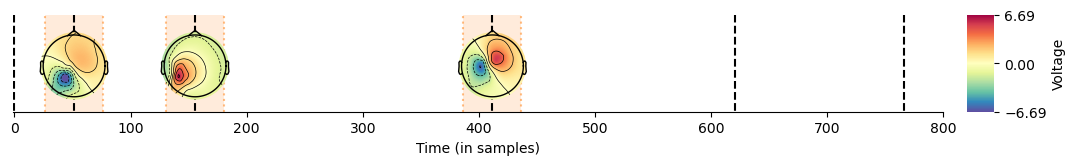

In [15]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}

sim_source_times = np.zeros((n_trials, n_events+2))*np.nan
for event in np.unique(events[:,2]):
    sim_source_times[:,event-1] = events[events[:,2] == event,0]
sim_source_times -= np.tile(sim_source_times[:,0], (n_events+2,1)).T
diff_source_times = np.diff(sim_source_times)
sim_source_times = sim_source_times[1:]

# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

# Transforming to PC space
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=5)

# Fitting
init = hmp.models.hmp(data=hmp_data)
estimates = init.fit(by_sample=False)#

#Plotting
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, times_to_display = np.mean(sim_source_times,axis=0))

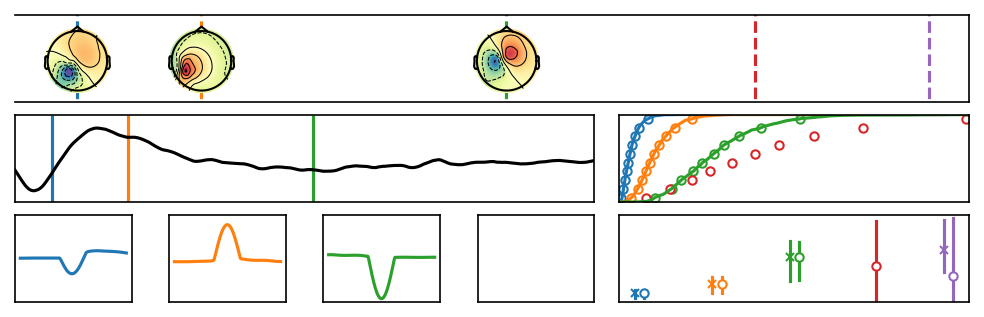

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2), dpi=150)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times = init.compute_times(init, estimates, fill_value=0, add_rt=True)
durations = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
probs_mean = estimates.eventprobs.mean('trial_x_participant')


# Comparing to initial model
index, corresp_true = simulations.classification_true(true_topologies, init.compute_topologies(eeg_data, estimates, init, mean=True))
dict_true_to_event = {i:j for i,j in zip(corresp_true, index)}
dict_event_to_true = {j:i for i,j in zip(corresp_true, index)}


ax0 = fig.add_subplot(gs[0, :5])
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, 
            times_to_display = np.mean(sim_source_times[:,1:],axis=0), ax=ax0, colorbar=False,event_lines=None, linecolors=list(color_dict.values()))
ax0.set_xticks([])
ax1 = fig.add_subplot(gs[1, :4])

# Plotting the single trial aligned events
for i in range(n_events):
    ax = fig.add_subplot(gs[2, i])
    if i in dict_event_to_true.values():
        ax1.vlines(times.mean('trial_x_participant')[dict_true_to_event[i]+1], -1, 1, color=color_dict[i])
        centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=dict_true_to_event[i]+1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_dict[i])
    ax.set(ylim=(-5.5, 5.5), xticks=[], yticks=[])
    
centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=0, n_samples=800, baseline=0)
ax1.plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color='k')
ax1.set(ylim=(-1, 1), xlim=(0, 800), xticks=[], yticks=[])


# Plotting durations and event probabilities
ax2_0 = fig.add_subplot(gs[1, 4])
for i in range(n_events):
    ax2_0.plot(np.percentile(sim_source_times[:,i+1],q),q, 'o', markerfacecolor='w', color=color_dict[i], ms=4, zorder=-1)
    if i in dict_event_to_true.keys():
        ax2_0.plot(probs_mean[:,i].cumsum()*100, ls='-', color=color_dict[dict_event_to_true[i]])
ax2_0.set(xlim=(0, 1500), ylim=(0, 100), xticks=[], yticks=[])


ax2_1 = fig.add_subplot(gs[2, 4])
for i in range(n_events+1):
    if i in dict_event_to_true.values():
        ax2_1.plot(np.repeat(i + 1, 2) - .06, np.percentile(durations[i, :].T, q=[25, 75]), color=color_dict[i])
        ax2_1.plot(i + 1 - .06, np.mean(durations[i, :].T), 'x', markeredgecolor=color_dict[i], markersize=4)
    ax2_1.plot(np.repeat(i + 1, 2) + .06, np.percentile(diff_source_times[:, i], q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 + .06,  np.mean(diff_source_times[:, i]), 'o', markerfacecolor='w', color=color_dict[i], markersize=4)
ax2_1.plot(np.repeat(n_events + 1, 2) - .06, np.percentile(durations[-1, :].T, q=[25, 75]), color=color_dict[n_events])
ax2_1.plot(n_events + 1 - .06, np.percentile(durations[-1, :].T, q=[50]), 'x', markeredgecolor=color_dict[n_events], markersize=4)
ax2_1.set(ylim=(0, 500), xticks=[], yticks=[])
plt.savefig('plots/%s'%name_file,dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [17]:
name_file = 'dataset-simult'
means = np.array([50, 100, 250, 250,  350])/shape #Mean duration of the between event times in ms
relations = [1,2,3,3,5] # to which previous event each event is related (1 is stimulus onset)


sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency,  amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, name_file, path='data/', 
            overwrite=False, sfreq=sfreq, noise=False, seed=1234,
            relations=relations, proportions=proportions, 
            event_length_samples=event_length_samples)

#load electrode position, specific to the simulations
positions = simulations.simulation_positions()


/home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/illustration/simulations.py:190: UserWarning: data/dataset-simult_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant data/dataset-simult_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


998 trials were retained for participant data/dataset-simult_raw.fif


  0%|          | 0/770 [00:00<?, ?it/s]

Transition event 1 found around sample 51
Transition event 2 found around sample 162
Transition event 3 found around sample 364
Transition event 4 found around sample 514

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


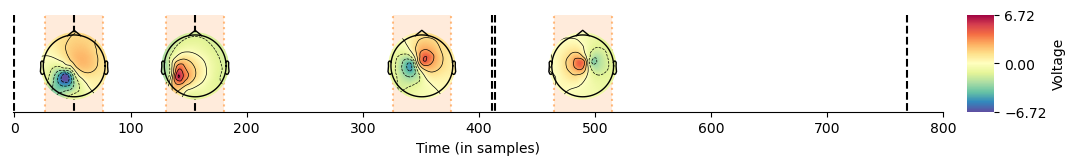

In [18]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}

sim_source_times = np.zeros((n_trials, n_events+2))*np.nan
for event in np.unique(events[:,2]):
    sim_source_times[:,event-1] = events[events[:,2] == event,0]
sim_source_times -= np.tile(sim_source_times[:,0], (n_events+2,1)).T
diff_source_times = np.diff(sim_source_times)
sim_source_times = sim_source_times[1:]

# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

# Transforming to PC space
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=5)

# Fitting
init = hmp.models.hmp(data=hmp_data)
estimates = init.fit()#

#Plotting
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, times_to_display = np.mean(sim_source_times,axis=0))

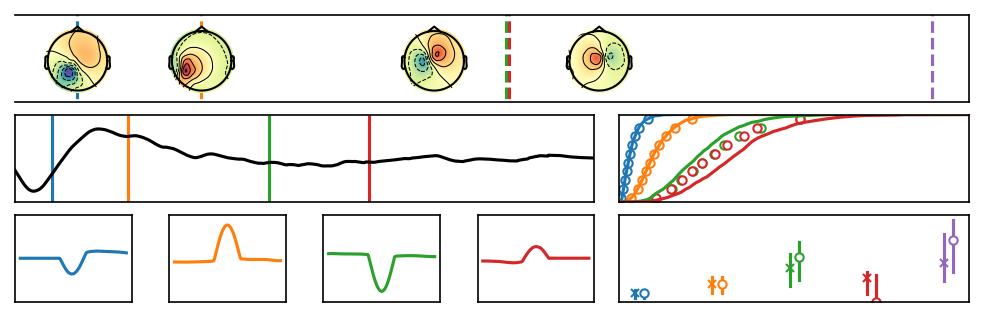

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2), dpi=150)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times = init.compute_times(init, estimates, fill_value=0, add_rt=True)
durations = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
probs_mean = estimates.eventprobs.mean('trial_x_participant')


# Comparing to initial model
index, corresp_true = simulations.classification_true(true_topologies, init.compute_topologies(eeg_data, estimates, init, mean=True))
dict_true_to_event = {i:j for i,j in zip(corresp_true, index)}
dict_event_to_true = {j:i for i,j in zip(corresp_true, index)}


ax0 = fig.add_subplot(gs[0, :5])
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, 
            times_to_display = np.mean(sim_source_times[:,1:],axis=0), ax=ax0, colorbar=False,event_lines=None, linecolors=list(color_dict.values()))
ax0.set_xticks([])
ax1 = fig.add_subplot(gs[1, :4])

# Plotting the single trial aligned events
for i in range(n_events):
    ax = fig.add_subplot(gs[2, i])
    if i in dict_event_to_true.values():
        ax1.vlines(times.mean('trial_x_participant')[dict_true_to_event[i]+1], -1, 1, color=color_dict[i])
        centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=dict_true_to_event[i]+1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_dict[i])
    ax.set(ylim=(-5.5, 5.5), xticks=[], yticks=[])
    
centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=0, n_samples=800, baseline=0)
ax1.plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color='k')
ax1.set(ylim=(-1, 1), xlim=(0, 800), xticks=[], yticks=[])


# Plotting durations and event probabilities
ax2_0 = fig.add_subplot(gs[1, 4])
for i in range(n_events):
    ax2_0.plot(np.percentile(sim_source_times[:,i+1],q),q, 'o', markerfacecolor='w', color=color_dict[i], ms=4, zorder=-1)
    if i in dict_event_to_true.keys():
        ax2_0.plot(probs_mean[:,i].cumsum()*100, ls='-', color=color_dict[dict_event_to_true[i]])
ax2_0.set(xlim=(0, 1500), ylim=(0, 100), xticks=[], yticks=[])


ax2_1 = fig.add_subplot(gs[2, 4])
for i in range(n_events+1):
    if i in dict_event_to_true.values():
        ax2_1.plot(np.repeat(i + 1, 2) - .06, np.percentile(durations[i, :].T, q=[25, 75]), color=color_dict[i])
        ax2_1.plot(i + 1 - .06, np.mean(durations[i, :].T), 'x', markeredgecolor=color_dict[i], markersize=4)
    ax2_1.plot(np.repeat(i + 1, 2) + .06, np.percentile(diff_source_times[:, i], q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 + .06,  np.mean(diff_source_times[:, i]), 'o', markerfacecolor='w', color=color_dict[i], markersize=4)
ax2_1.plot(np.repeat(n_events + 1, 2) - .06, np.percentile(durations[-1, :].T, q=[25, 75]), color=color_dict[n_events])
ax2_1.plot(n_events + 1 - .06, np.percentile(durations[-1, :].T, q=[50]), 'x', markeredgecolor=color_dict[n_events], markersize=4)
ax2_1.set(ylim=(0, 500), xticks=[], yticks=[])
plt.savefig('plots/%s'%name_file,dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [20]:
name_file = 'dataset-alpha_npl'

means = np.array([50, 100, 250, 450,  150])/shape #Mean duration of the between event times in ms
relations = [1,2,1,3,5] # to which previous event each event is related (1 is stimulus onset)
event_length_samples = [50, 50, 1500, 50, 50] # The sampling period of the event (e.g. 100 is full sine)

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency,  amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, name_file, path='data/',\
            overwrite=False, sfreq=sfreq, noise=False, seed=1234,
            relations=relations, proportions=proportions, 
            event_length_samples=event_length_samples)


/home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/illustration/simulations.py:190: UserWarning: data/dataset-alpha_npl_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant data/dataset-alpha_npl_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant data/dataset-alpha_npl_raw.fif


  0%|          | 0/769 [00:00<?, ?it/s]

Transition event 1 found around sample 51
Transition event 2 found around sample 410
Transition event 3 found around sample 617

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model


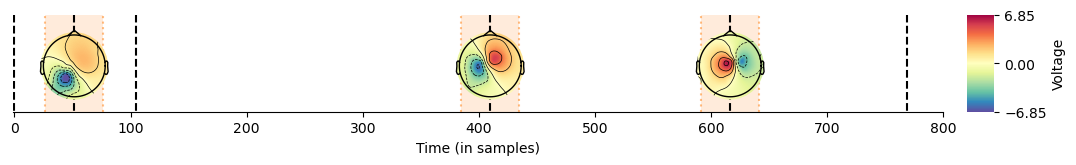

In [21]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}

sim_source_times = np.zeros((n_trials, n_events+2))*np.nan
for event in np.unique(events[:,2]):
    sim_source_times[:,event-1] = events[events[:,2] == event,0]
sim_source_times -= np.tile(sim_source_times[:,0], (n_events+2,1)).T
diff_source_times = np.diff(sim_source_times)
sim_source_times = sim_source_times[1:]

# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

# Transforming to PC space
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=5)

# Fitting
init = hmp.models.hmp(data=hmp_data)
estimates = init.fit()#
#Plotting
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, times_to_display = np.mean(sim_source_times,axis=0))

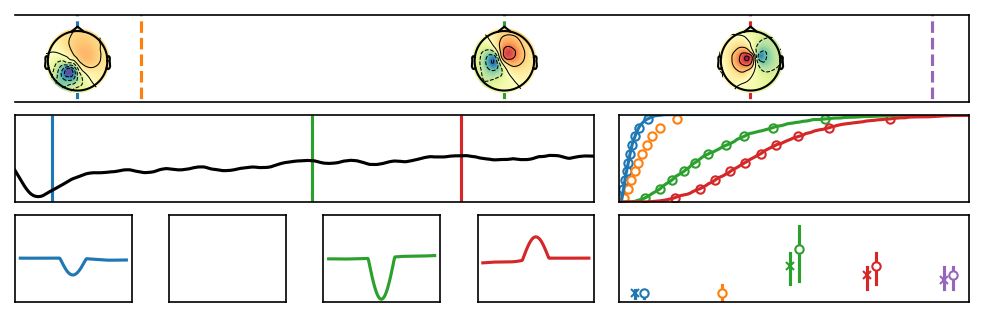

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2), dpi=150)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times = init.compute_times(init, estimates, fill_value=0, add_rt=True)
durations = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
probs_mean = estimates.eventprobs.mean('trial_x_participant')


# Comparing to initial model
index, corresp_true = simulations.classification_true(true_topologies, init.compute_topologies(eeg_data, estimates, init, mean=True))
dict_true_to_event = {i:j for i,j in zip(corresp_true, index)}
dict_event_to_true = {j:i for i,j in zip(corresp_true, index)}


ax0 = fig.add_subplot(gs[0, :5])
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, 
            times_to_display = np.mean(sim_source_times[:,1:],axis=0), ax=ax0, colorbar=False,event_lines=None, linecolors=list(color_dict.values()))
ax0.set_xticks([])
ax1 = fig.add_subplot(gs[1, :4])

# Plotting the single trial aligned events
for i in range(n_events):
    ax = fig.add_subplot(gs[2, i])
    if i in dict_event_to_true.values():
        ax1.vlines(times.mean('trial_x_participant')[dict_true_to_event[i]+1], -1, 1, color=color_dict[i])
        centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=dict_true_to_event[i]+1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_dict[i])
    ax.set(ylim=(-5.5, 5.5), xticks=[], yticks=[])
    
centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=0, n_samples=800, baseline=0)
ax1.plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color='k')
ax1.set(ylim=(-1, 1), xlim=(0, 800), xticks=[], yticks=[])


# Plotting durations and event probabilities
ax2_0 = fig.add_subplot(gs[1, 4])
for i in range(n_events):
    ax2_0.plot(np.percentile(sim_source_times[:,i+1],q),q, 'o', markerfacecolor='w', color=color_dict[i], ms=4, zorder=-1)
    if i in dict_event_to_true.keys():
        ax2_0.plot(probs_mean[:,i].cumsum()*100, ls='-', color=color_dict[dict_event_to_true[i]])
ax2_0.set(xlim=(0, 1500), ylim=(0, 100), xticks=[], yticks=[])


ax2_1 = fig.add_subplot(gs[2, 4])
for i in range(n_events+1):
    if i in dict_event_to_true.values():
        ax2_1.plot(np.repeat(i + 1, 2) - .06, np.percentile(durations[i, :].T, q=[25, 75]), color=color_dict[i])
        ax2_1.plot(i + 1 - .06, np.mean(durations[i, :].T), 'x', markeredgecolor=color_dict[i], markersize=4)
    ax2_1.plot(np.repeat(i + 1, 2) + .06, np.percentile(diff_source_times[:, i], q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 + .06,  np.mean(diff_source_times[:, i]), 'o', markerfacecolor='w', color=color_dict[i], markersize=4)
ax2_1.plot(np.repeat(n_events + 1, 2) - .06, np.percentile(durations[-1, :].T, q=[25, 75]), color=color_dict[n_events])
ax2_1.plot(n_events + 1 - .06, np.percentile(durations[-1, :].T, q=[50]), 'x', markeredgecolor=color_dict[n_events], markersize=4)
ax2_1.set(ylim=(0, 500), xticks=[], yticks=[])
plt.savefig('plots/%s'%name_file,dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [23]:

name_file = 'dataset-alpha_pl'

means = np.array([50,  0.0001,350, 200,  150])/shape #Mean duration of the between event times in ms
relations = [1,1,2,4,5] # to which previous event each event is related (1 is stimulus onset)
event_length_samples = [50, 1500, 50, 50, 50] # The sampling period of the event (e.g. 100 is full sine)


sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency,  amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, name_file, path='data/',\
            overwrite=False, sfreq=sfreq, noise=False, seed=1234,
            relations=relations, proportions=proportions, 
            event_length_samples=event_length_samples)

/home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/illustration/simulations.py:190: UserWarning: data/dataset-alpha_pl_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant data/dataset-alpha_pl_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant data/dataset-alpha_pl_raw.fif


  0%|          | 0/769 [00:00<?, ?it/s]

Transition event 1 found around sample 51
Transition event 2 found around sample 410
Transition event 3 found around sample 617

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model


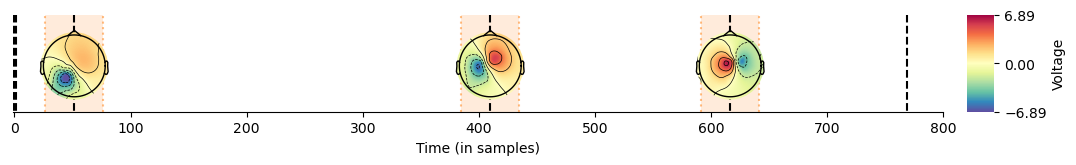

In [24]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}

sim_source_times = np.zeros((n_trials, n_events+2))*np.nan
for event in np.unique(events[:,2]):
    sim_source_times[:,event-1] = events[events[:,2] == event,0]
sim_source_times -= np.tile(sim_source_times[:,0], (n_events+2,1)).T
diff_source_times = np.diff(sim_source_times)
sim_source_times = sim_source_times[1:]

# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

# Transforming to PC space
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=5)

# Fitting
init = hmp.models.hmp(data=hmp_data)
estimates = init.fit()#

#Plotting
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, times_to_display = np.mean(sim_source_times,axis=0))

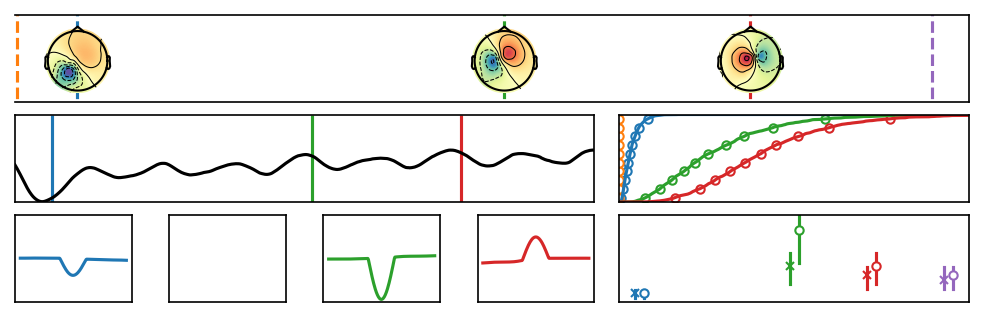

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2), dpi=150)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times = init.compute_times(init, estimates, fill_value=0, add_rt=True)
durations = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
probs_mean = estimates.eventprobs.mean('trial_x_participant')


# Comparing to initial model
index, corresp_true = simulations.classification_true(true_topologies, init.compute_topologies(eeg_data, estimates, init, mean=True))
dict_true_to_event = {i:j for i,j in zip(corresp_true, index)}
dict_event_to_true = {j:i for i,j in zip(corresp_true, index)}


ax0 = fig.add_subplot(gs[0, :5])
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, 
            times_to_display = np.mean(sim_source_times[:,1:],axis=0), ax=ax0, colorbar=False,event_lines=None, linecolors=list(color_dict.values()))
ax0.set_xticks([])
ax1 = fig.add_subplot(gs[1, :4])

# Plotting the single trial aligned events
for i in range(n_events):
    ax = fig.add_subplot(gs[2, i])
    if i in dict_event_to_true.values():
        ax1.vlines(times.mean('trial_x_participant')[dict_true_to_event[i]+1], -1, 1, color=color_dict[i])
        centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=dict_true_to_event[i]+1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_dict[i])
    ax.set(ylim=(-5.5, 5.5), xticks=[], yticks=[])
    
centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=0, n_samples=800, baseline=0)
ax1.plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color='k')
ax1.set(ylim=(-1, 1), xlim=(0, 800), xticks=[], yticks=[])


# Plotting durations and event probabilities
ax2_0 = fig.add_subplot(gs[1, 4])
for i in range(n_events):
    ax2_0.plot(np.percentile(sim_source_times[:,i+1],q),q, 'o', markerfacecolor='w', color=color_dict[i], ms=4, zorder=-1)
    if i in dict_event_to_true.keys():
        ax2_0.plot(probs_mean[:,i].cumsum()*100, ls='-', color=color_dict[dict_event_to_true[i]])
ax2_0.set(xlim=(0, 1500), ylim=(0, 100), xticks=[], yticks=[])


ax2_1 = fig.add_subplot(gs[2, 4])
for i in range(n_events+1):
    if i in dict_event_to_true.values():
        ax2_1.plot(np.repeat(i + 1, 2) - .06, np.percentile(durations[i, :].T, q=[25, 75]), color=color_dict[i])
        ax2_1.plot(i + 1 - .06, np.mean(durations[i, :].T), 'x', markeredgecolor=color_dict[i], markersize=4)
    ax2_1.plot(np.repeat(i + 1, 2) + .06, np.percentile(diff_source_times[:, i], q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 + .06,  np.mean(diff_source_times[:, i]), 'o', markerfacecolor='w', color=color_dict[i], markersize=4)
ax2_1.plot(np.repeat(n_events + 1, 2) - .06, np.percentile(durations[-1, :].T, q=[25, 75]), color=color_dict[n_events])
ax2_1.plot(n_events + 1 - .06, np.percentile(durations[-1, :].T, q=[50]), 'x', markeredgecolor=color_dict[n_events], markersize=4)
ax2_1.set(ylim=(0, 500), xticks=[], yticks=[])
plt.savefig('plots/%s'%name_file,dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [26]:
name_file = 'dataset_prop40'

means = np.array([50, 100, 250, 200,  150])/shape #Mean duration of the between event times in ms
relations = [1,2,3,4,5] # to which previous event each event is related (1 is stimulus onset)
proportions = [1,1,.40,1,1] # How frequent each event is
event_length_samples = [50, 50, 50, 50, 50] # The sampling period of the event (e.g. 100 is full sine)


sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency,  amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, name_file, path='data/', 
            overwrite=False, sfreq=sfreq, noise=False, seed=1234,
            relations=relations, proportions=proportions, 
            event_length_samples=event_length_samples)


/home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/illustration/simulations.py:190: UserWarning: data/dataset_prop40_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant data/dataset_prop40_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant data/dataset_prop40_raw.fif


  0%|          | 0/601 [00:00<?, ?it/s]

Transition event 1 found around sample 51
Transition event 2 found around sample 163
Transition event 3 found around sample 381
Transition event 4 found around sample 465

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


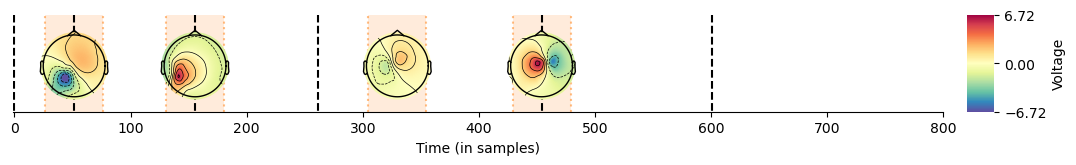

In [27]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}

sim_source_times = np.zeros((n_trials, n_events+2))*np.nan
for event in np.unique(events[:,2]):
    sim_source_times[:,event-1] = events[events[:,2] == event,0]
sim_source_times -= np.tile(sim_source_times[:,0], (n_events+2,1)).T
diff_source_times = np.diff(sim_source_times)
sim_source_times = sim_source_times[1:]

# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

# Transforming to PC space
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=5)

# Fitting
init = hmp.models.hmp(data=hmp_data)
estimates = init.fit()#

#Plotting
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, times_to_display = np.mean(sim_source_times,axis=0))

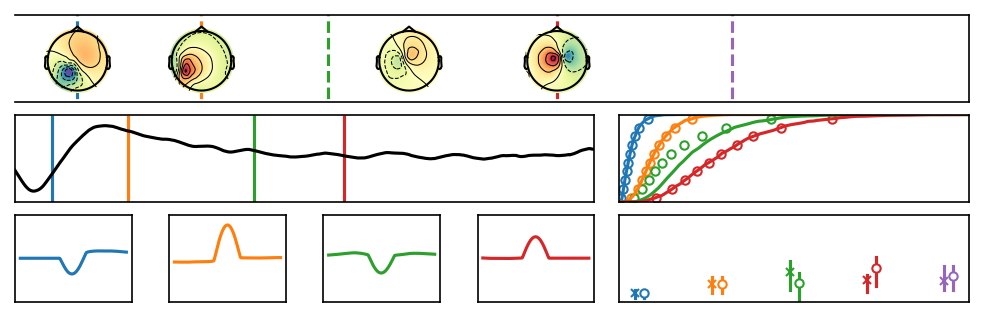

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2), dpi=150)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times = init.compute_times(init, estimates, fill_value=0, add_rt=True)
durations = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
probs_mean = estimates.eventprobs.mean('trial_x_participant')


# Comparing to initial model
index, corresp_true = simulations.classification_true(true_topologies, init.compute_topologies(eeg_data, estimates, init, mean=True))
dict_true_to_event = {i:j for i,j in zip(corresp_true, index)}
dict_event_to_true = {j:i for i,j in zip(corresp_true, index)}


ax0 = fig.add_subplot(gs[0, :5])
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, 
            times_to_display = np.mean(sim_source_times[:,1:],axis=0), ax=ax0, colorbar=False,event_lines=None, linecolors=list(color_dict.values()))
ax0.set_xticks([])
ax1 = fig.add_subplot(gs[1, :4])

# Plotting the single trial aligned events
for i in range(n_events):
    ax = fig.add_subplot(gs[2, i])
    if i in dict_event_to_true.values():
        ax1.vlines(times.mean('trial_x_participant')[dict_true_to_event[i]+1], -1, 1, color=color_dict[i])
        centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=dict_true_to_event[i]+1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_dict[i])
    ax.set(ylim=(-5.5, 5.5), xticks=[], yticks=[])
    
centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=0, n_samples=800, baseline=0)
ax1.plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color='k')
ax1.set(ylim=(-1, 1), xlim=(0, 800), xticks=[], yticks=[])


# Plotting durations and event probabilities
ax2_0 = fig.add_subplot(gs[1, 4])
for i in range(n_events):
    ax2_0.plot(np.percentile(sim_source_times[:,i+1],q),q, 'o', markerfacecolor='w', color=color_dict[i], ms=4, zorder=-1)
    if i in dict_event_to_true.keys():
        ax2_0.plot(probs_mean[:,i].cumsum()*100, ls='-', color=color_dict[dict_event_to_true[i]])
ax2_0.set(xlim=(0, 1500), ylim=(0, 100), xticks=[], yticks=[])


ax2_1 = fig.add_subplot(gs[2, 4])
for i in range(n_events+1):
    if i in dict_event_to_true.values():
        ax2_1.plot(np.repeat(i + 1, 2) - .06, np.percentile(durations[i, :].T, q=[25, 75]), color=color_dict[i])
        ax2_1.plot(i + 1 - .06, np.mean(durations[i, :].T), 'x', markeredgecolor=color_dict[i], markersize=4)
    ax2_1.plot(np.repeat(i + 1, 2) + .06, np.percentile(diff_source_times[:, i], q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 + .06,  np.mean(diff_source_times[:, i]), 'o', markerfacecolor='w', color=color_dict[i], markersize=4)
ax2_1.plot(np.repeat(n_events + 1, 2) - .06, np.percentile(durations[-1, :].T, q=[25, 75]), color=color_dict[n_events])
ax2_1.plot(n_events + 1 - .06, np.percentile(durations[-1, :].T, q=[50]), 'x', markeredgecolor=color_dict[n_events], markersize=4)
ax2_1.set(ylim=(0, 500), xticks=[], yticks=[])
plt.savefig('plots/%s'%name_file,dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [29]:
name_file = 'dataset_prop20'

means = np.array([50, 100, 250, 200,  150])/shape #Mean duration of the between event times in ms
relations = [1,2,3,4,5] # to which previous event each event is related (1 is stimulus onset)
proportions = [1,1,.2,1,1] # How frequent each event is
event_length_samples = [50, 50, 50, 50, 50] # The sampling period of the event (e.g. 100 is full sine)


sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency,  amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, name_file, path='data/',
            overwrite=False, sfreq=sfreq, noise=False, seed=1234,
            relations=relations, proportions=proportions, 
            event_length_samples=event_length_samples)


/home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/illustration/simulations.py:190: UserWarning: data/dataset_prop20_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant data/dataset_prop20_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


1000 trials were retained for participant data/dataset_prop20_raw.fif


  0%|          | 0/549 [00:00<?, ?it/s]

Transition event 1 found around sample 51
Transition event 2 found around sample 163
Transition event 3 found around sample 408

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model


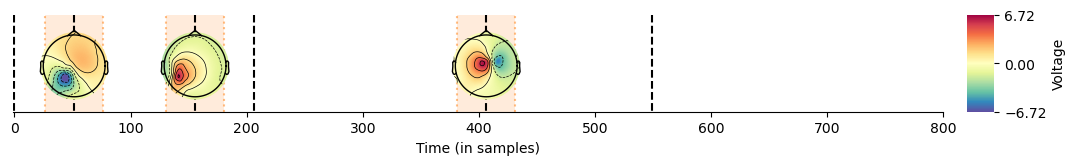

In [30]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}

sim_source_times = np.zeros((n_trials, n_events+2))*np.nan
for event in np.unique(events[:,2]):
    sim_source_times[:,event-1] = events[events[:,2] == event,0]
sim_source_times -= np.tile(sim_source_times[:,0], (n_events+2,1)).T
diff_source_times = np.diff(sim_source_times)
sim_source_times = sim_source_times[1:]

# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

# Transforming to PC space
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=5)

# Fitting
init = hmp.models.hmp(data=hmp_data)
estimates = init.fit()#

#Plotting
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, times_to_display = np.mean(sim_source_times,axis=0))

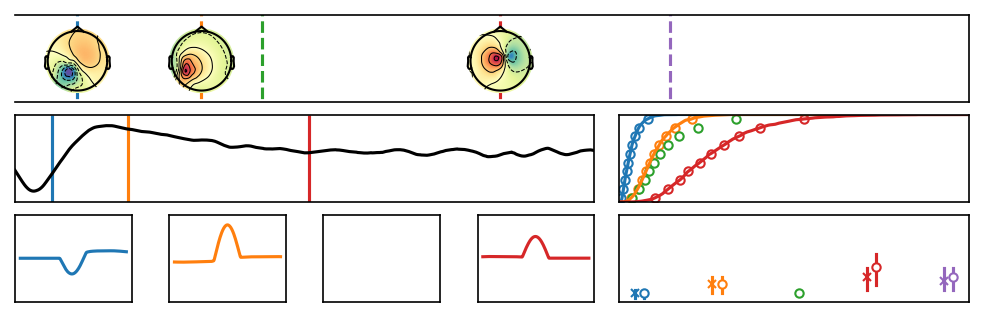

In [31]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2), dpi=150)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
times = init.compute_times(init, estimates, fill_value=0, add_rt=True)
durations = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
probs_mean = estimates.eventprobs.mean('trial_x_participant')


# Comparing to initial model
index, corresp_true = simulations.classification_true(true_topologies, init.compute_topologies(eeg_data, estimates, init, mean=True))
dict_true_to_event = {i:j for i,j in zip(corresp_true, index)}
dict_event_to_true = {j:i for i,j in zip(corresp_true, index)}


ax0 = fig.add_subplot(gs[0, :5])
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, max_time=800,magnify=1, sensors=False, 
            times_to_display = np.mean(sim_source_times[:,1:],axis=0), ax=ax0, colorbar=False,event_lines=None, linecolors=list(color_dict.values()))
ax0.set_xticks([])
ax1 = fig.add_subplot(gs[1, :4])

# Plotting the single trial aligned events
for i in range(n_events):
    ax = fig.add_subplot(gs[2, i])
    if i in dict_event_to_true.values():
        ax1.vlines(times.mean('trial_x_participant')[dict_true_to_event[i]+1], -1, 1, color=color_dict[i])
        centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=dict_true_to_event[i]+1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples, centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color=color_dict[i])
    ax.set(ylim=(-5.5, 5.5), xticks=[], yticks=[])
    
centered = hmp.utils.centered_activity(data, times, ["EEG 038"], event=0, n_samples=800, baseline=0)
ax1.plot(centered.data.unstack().mean(['trials', 'channel', 'participant']).data, color='k')
ax1.set(ylim=(-1, 1), xlim=(0, 800), xticks=[], yticks=[])


# Plotting durations and event probabilities
ax2_0 = fig.add_subplot(gs[1, 4])
for i in range(n_events):
    ax2_0.plot(np.percentile(sim_source_times[:,i+1],q),q, 'o', markerfacecolor='w', color=color_dict[i], ms=4, zorder=-1)
    if i in dict_event_to_true.keys():
        ax2_0.plot(probs_mean[:,i].cumsum()*100, ls='-', color=color_dict[dict_event_to_true[i]])
ax2_0.set(xlim=(0, 1500), ylim=(0, 100), xticks=[], yticks=[])


ax2_1 = fig.add_subplot(gs[2, 4])
for i in range(n_events+1):
    if i in dict_event_to_true.values():
        ax2_1.plot(np.repeat(i + 1, 2) - .06, np.percentile(durations[i, :].T, q=[25, 75]), color=color_dict[i])
        ax2_1.plot(i + 1 - .06, np.mean(durations[i, :].T), 'x', markeredgecolor=color_dict[i], markersize=4)
    ax2_1.plot(np.repeat(i + 1, 2) + .06, np.percentile(diff_source_times[:, i], q=[25, 75]), color=color_dict[i])
    ax2_1.plot(i + 1 + .06,  np.mean(diff_source_times[:, i]), 'o', markerfacecolor='w', color=color_dict[i], markersize=4)

ax2_1.plot(np.repeat(n_events + 1, 2) - .06, np.percentile(durations[-1, :].T, q=[25, 75]), color=color_dict[n_events])
ax2_1.plot(n_events + 1 - .06, np.percentile(durations[-1, :].T, q=[50]), 'x', markeredgecolor=color_dict[n_events], markersize=4)
ax2_1.set(ylim=(0, 500), xticks=[], yticks=[])
plt.savefig('plots/%s'%name_file,dpi=300,transparent=True,bbox_inches='tight')
plt.show()